## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import uniform

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings

warnings.filterwarnings("ignore")

## Обзор данных

#### Чтение датасета

In [2]:
df = pd.read_csv("../data/airlines_dataset.csv")

In [3]:
df.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,400740,XE,3036,IAH,CHS,4.0,1195,131.0,0
1,194808,UA,315,DEN,ONT,7.0,707,145.0,0


#### Обзор столбцов датасета

- `id` - номер вылета
- `Airline` - страна, которой принадлежит борт
- `Flight` - номер борта
- `AirportFrom` - аэропорт отправления
- `AirportTo` - аэропорт прибытия
- `DayOfWeek` - день недели
- `Time` - общее время налёта
- `Length` - общее расстояние полётов
- `Delay`- статус задержки

#### Получение информации о данных в столбцах датафрейма

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           400000 non-null  int64  
 1   Airline      399264 non-null  object 
 2   Flight       400000 non-null  int64  
 3   AirportFrom  400000 non-null  object 
 4   AirportTo    398843 non-null  object 
 5   DayOfWeek    399673 non-null  float64
 6   Time         400000 non-null  int64  
 7   Length       399517 non-null  float64
 8   Delay        400000 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 27.5+ MB


#### Выводы

- Заголовки нужно привести к lower case и заменить разделение заглавными буквами на знаки нижнего подчёркивания
- Требуется привести столбцы `Airline`, `AirportFrom` и `AirportTo` к числовому формату 
- Требуется обработка пропущенных значений
- Требуется обработка дубликатов
- Требуется удалить столбец id

## Предварительная обработка датасета

#### Форматирование заголовков датафрейма

In [5]:
df.columns = [column.strip().lower() for column in df.columns]

df = df.rename(columns={"airportfrom": "airport_from", "airportto": "airport_to", "dayofweek": "day_of_week"})

In [6]:
df.columns

Index(['id', 'airline', 'flight', 'airport_from', 'airport_to', 'day_of_week',
       'time', 'length', 'delay'],
      dtype='object')

#### Обработка пропущенных значений

In [7]:
df = df.dropna()

#### Обработка дубликатов

In [8]:
df = df.drop_duplicates()

#### Приведение категориальных признаков к числовому типу

In [9]:
label_encoder = LabelEncoder()

In [10]:
df["airline"] = label_encoder.fit_transform(df["airline"])

In [11]:
df["airport_from"] = label_encoder.fit_transform(df["airport_from"])

In [12]:
df["airport_to"] = label_encoder.fit_transform(df["airport_to"])

In [13]:
df.head(2)

,id,airline,flight,airport_from,airport_to,day_of_week,time,length,delay
0,400740,16,3036,135,54,4.0,1195,131.0,0
1,194808,13,315,79,207,7.0,707,145.0,0


#### Удаление первого столбца как неинформативного

In [14]:
del df["id"]

In [15]:
df.head()

,airline,flight,airport_from,airport_to,day_of_week,time,length,delay
0,16,3036,135,54,4.0,1195,131.0,0
1,13,315,79,207,7.0,707,145.0,0
2,12,6673,253,194,5.0,499,42.0,1
3,15,3668,217,207,2.0,810,70.0,1
4,2,623,153,214,5.0,985,143.0,0


#### Сохранение предобработанного датасета

In [16]:
df.to_csv("../data/preprocessed_airlines_dataset.csv")

## Подготовка данных к обучению

#### Разделение данных на матрицу признаков и предсказываемые значения

In [17]:
y = df.loc[:, "delay"]
X = df.drop("delay", axis=1)

#### Разбиение данных на обучающую и тестовую выборки

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Масштабирование признаков

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Проверка балансировки классов

In [20]:
y.value_counts()

delay
0    297096
1    100211
Name: count, dtype: int64

Баланс классов приемлемый

## Обучение классификаторов

#### Метод для оценки качества

In [21]:
def quality_assessment(y_test: np.ndarray, y_pred: np.ndarray) -> None:
    print("[+] Accuracy:", accuracy_score(y_test, y_pred))
    print("[+] Confusion matrix:", *confusion_matrix(y_test, y_pred))
    print("[+] Classification report:", classification_report(y_test, y_pred))

#### KNN

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [23]:
quality_assessment(y_test, y_pred)

[+] Accuracy: 0.7380772599595277
[+] Confusion matrix: [66727  7664] [18352  6584]
[+] Classification report:               precision    recall  f1-score   support

           0       0.78      0.90      0.84     74391
           1       0.46      0.26      0.34     24936

    accuracy                           0.74     99327
   macro avg       0.62      0.58      0.59     99327
weighted avg       0.70      0.74      0.71     99327



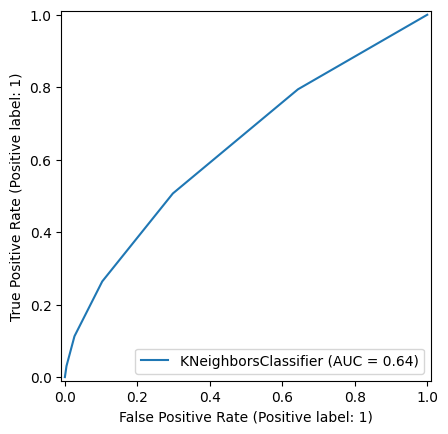

In [24]:
RocCurveDisplay.from_estimator(knn, X_test, y_test)

#### Оптимизированный KNN

In [25]:
params = {"n_neighbors": [1, 3, 5, 7, 9], "metric": ["euclidean", "manhattan", "minkowski"]}

In [26]:
# НЕ ЗАПУСКАТЬ!

# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

# print("[+] Best parameters for KNN:", best_params)

In [27]:
random_search = RandomizedSearchCV(KNeighborsClassifier(), params, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

print("[+] Best parameters for KNN:", best_params)

[+] Best parameters for KNN: {'n_neighbors': 9, 'metric': 'manhattan'}


In [28]:
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [29]:
quality_assessment(y_test, y_pred)

[+] Accuracy: 0.7643238998459634
[+] Confusion matrix: [69330  5061] [18348  6588]
[+] Classification report:               precision    recall  f1-score   support

           0       0.79      0.93      0.86     74391
           1       0.57      0.26      0.36     24936

    accuracy                           0.76     99327
   macro avg       0.68      0.60      0.61     99327
weighted avg       0.73      0.76      0.73     99327



#### Naive Bayes

In [30]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

In [31]:
quality_assessment(y_test, y_pred)

[+] Accuracy: 0.7464637007057497
[+] Confusion matrix: [73913   478] [24705   231]
[+] Classification report:               precision    recall  f1-score   support

           0       0.75      0.99      0.85     74391
           1       0.33      0.01      0.02     24936

    accuracy                           0.75     99327
   macro avg       0.54      0.50      0.44     99327
weighted avg       0.64      0.75      0.64     99327



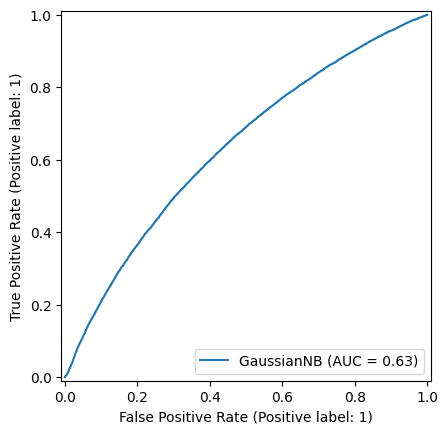

In [32]:
RocCurveDisplay.from_estimator(gnb, X_test, y_test)

#### Оптимизированный Naive Bayes

In [33]:
params = {"var_smoothing": uniform(loc=1e-9, scale=1)}

In [34]:
random_search = RandomizedSearchCV(GaussianNB(), params, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

print("[+] Best parameters for GNB:", best_params)

[+] Best parameters for GNB: {'var_smoothing': np.float64(0.9423500561843035)}


In [35]:
gnb = GaussianNB(**best_params)
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

In [36]:
quality_assessment(y_test, y_pred)

[+] Accuracy: 0.7489504364372225
[+] Confusion matrix: [74391     0] [24936     0]
[+] Classification report:               precision    recall  f1-score   support

           0       0.75      1.00      0.86     74391
           1       0.00      0.00      0.00     24936

    accuracy                           0.75     99327
   macro avg       0.37      0.50      0.43     99327
weighted avg       0.56      0.75      0.64     99327



#### Logistic Regression

In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [38]:
lr.score(X_test, y_test)

# quality_assessment(y_test, y_pred)

0.7481752192253869

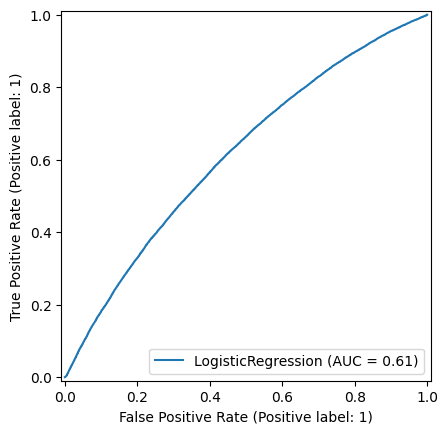

In [39]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)

#### Оптимизированная Logistic Regression

In [40]:
params = {"C": [0.1, 1, 10, 100], "penalty": ["l1", "l2"]}

In [41]:
random_search = RandomizedSearchCV(LogisticRegression(), params, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

print("[+] Best parameters for Logistic Regression:", best_params)

[+] Best parameters for Logistic Regression: {'penalty': 'l2', 'C': 0.1}


In [42]:
lr = LogisticRegression(**best_params)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [43]:
lr.score(X_test, y_test)

# quality_assessment(y_test, y_pred)

0.748165151469389

#### SVM

In [44]:
svc = LinearSVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [45]:
quality_assessment(y_test, y_pred)

[+] Accuracy: 0.748920233169229
[+] Confusion matrix: [74387     4] [24935     1]
[+] Classification report:               precision    recall  f1-score   support

           0       0.75      1.00      0.86     74391
           1       0.20      0.00      0.00     24936

    accuracy                           0.75     99327
   macro avg       0.47      0.50      0.43     99327
weighted avg       0.61      0.75      0.64     99327



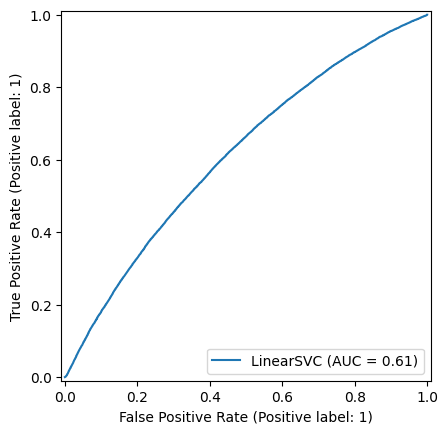

In [46]:
RocCurveDisplay.from_estimator(svc, X_test, y_test)

#### Оптимизированный SVM

In [47]:
params = {"C": uniform(0.01, 10.0), "penalty": ["l1", "l2"]}

In [48]:
random_search = RandomizedSearchCV(LinearSVC(), params, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

print("[+] Best parameters for SVM:", best_params)

[+] Best parameters for SVM: {'C': np.float64(0.031267008522013466), 'penalty': 'l2'}


In [49]:
svc = LinearSVC(**best_params)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [50]:
quality_assessment(y_test, y_pred)

[+] Accuracy: 0.748920233169229
[+] Confusion matrix: [74387     4] [24935     1]
[+] Classification report:               precision    recall  f1-score   support

           0       0.75      1.00      0.86     74391
           1       0.20      0.00      0.00     24936

    accuracy                           0.75     99327
   macro avg       0.47      0.50      0.43     99327
weighted avg       0.61      0.75      0.64     99327



## Вывод

Наиболее хорошо себя показала модель `KNN` с `AUC=0.64`.